This notebook contains experiments with the dataset "Concrete Crack Images for Classification" which has 20000 positive crack images, 20000 negative (no cracks) images.Deep Learning Based Pavement Inspection Using Self-Reconfigurable Robot


# Imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as tf_hub
import os
import shutil
import matplotlib.pyplot as plt

from glob import glob
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import confusion_matrix,classification_report

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Dataset Prep: Train-test split

Naive (no data processing). We can try different data processing methods in a different notebook.

In [3]:
negative_imgs = glob('/kaggle/input/concrete-crack-images-for-classification/Concrete/Negative/*')
positive_imgs = glob('/kaggle/input/concrete-crack-images-for-classification/Concrete/Positive/*')
len(negative_imgs), len(positive_imgs)

(20000, 20000)

In [4]:
negative_train, negative_test = train_test_split(negative_imgs, test_size=0.1,
                                       random_state=42)
positive_train, positive_test = train_test_split(positive_imgs,
                                             test_size=0.1,
                                             random_state=42)

In [5]:
!mkdir /kaggle/working/train/
!mkdir /kaggle/working/test

In [6]:
!mkdir /kaggle/working/train/positive
!mkdir /kaggle/working/test/positive
!mkdir /kaggle/working/train/negative
!mkdir /kaggle/working/test/negative

In [7]:
TRAIN_POSITIVE_PATH = '/kaggle/working/train/positive/'
TRAIN_NEGATIVE_PATH = '/kaggle/working/train/negative/'

TEST_POSITIVE_PATH = '/kaggle/working/test/positive/'
TEST_NEGATIVE_PATH = '/kaggle/working/test/negative/'

for path in tqdm(positive_train, 
                 desc='Creating Train Dataset (positive)'):
    fn = path.split('/')[-1]
    shutil.copy(path, TRAIN_POSITIVE_PATH+fn)

for path in tqdm(negative_train, 
                 desc='Creating Train Dataset (negative)'):
    fn = path.split('/')[-1]
    shutil.copy(path, TRAIN_NEGATIVE_PATH+fn)

for path in tqdm(positive_test, 
                 desc='Creating Test Dataset (positive)'):
    fn = path.split('/')[-1]
    shutil.copy(path, TEST_POSITIVE_PATH+fn)

for path in tqdm(negative_test, 
                 desc='Creating Test Dataset (negative)'):
    fn = path.split('/')[-1]
    shutil.copy(path, TEST_NEGATIVE_PATH+fn)

Creating Test Dataset (negative): 100%|██████████| 2000/2000 [00:13<00:00, 150.68it/s]


In [8]:
TRAIN_PATH = '/kaggle/working/train/'
TEST_PATH = '/kaggle/working/test/'

In [9]:
IMG_DIMS = (227, 227)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['negative', 'positive']

In [10]:
def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        TRAIN_PATH,
        validation_split=0.1,
        subset="training",
        class_names=classes,
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        TRAIN_PATH,
        validation_split=0.1,
        subset="validation",
        class_names=classes,
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

In [11]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 36000 files belonging to 2 classes.
Using 32400 files for training.


2022-03-20 11:34:55.297024: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-20 11:34:55.398590: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-20 11:34:55.399382: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-20 11:34:55.401559: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 36000 files belonging to 2 classes.
Using 3600 files for validation.


2022-03-20 11:35:00.993224: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


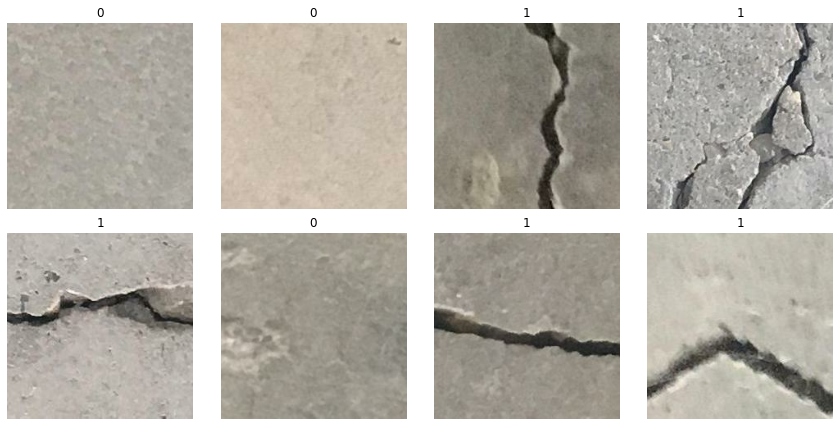

In [12]:
plt.figure(figsize=(12, 6))

for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()

# Resnet50 transfer learning

In [13]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.\
            RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.\
           RandomRotation(0.1),
        tf.keras.layers.experimental.preprocessing.\
            RandomZoom(height_factor=(0.1,0.3),
                       width_factor=(0.1,0.3))
    ]
)

In [14]:
exft_base_resnet50 = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=IMG_SHAPE,
    weights='imagenet'
)
exft_base_resnet50.trainable = True

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = tf.keras.applications.resnet.preprocess_input(x)
x = exft_base_resnet50(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=0.3)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=0.3)(x)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

lr_finetuned_resnet50 = tf.keras.Model(inputs, outputs)

94781440/94765736 [==============================] - 1s 0us/step


In [15]:
def lr_function(epoch):
    start_lr = 1e-5; min_lr = 1e-5; max_lr = 1e-4
    rampup_epochs = 5; sustain_epochs = 0; exp_decay = .8
    
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, 
           sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) / rampup_epochs 
                        * epoch + start_lr)
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = ((max_lr - min_lr) * 
                      exp_decay**(epoch - rampup_epochs -
                                    sustain_epochs) + min_lr)
        return lr

    return lr(epoch, start_lr, min_lr, max_lr, 
              rampup_epochs, sustain_epochs, exp_decay)

In [16]:
epochs = 100

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                     patience=5, 
                                     restore_best_weights=True),
    tf.keras.callbacks.LearningRateScheduler(lambda epoch: \
                                             lr_function(epoch), 
                                             verbose=True)
    
]

lr_finetuned_resnet50.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

history = lr_finetuned_resnet50.fit(
    train_ds, epochs=epochs, callbacks=callbacks, 
    validation_data=val_ds,
)

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 1e-05.


2022-03-20 11:35:20.898904: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1013/1013 [==============================] - 254s 238ms/step - loss: 0.0144 - accuracy: 0.9954 - val_loss: 0.0068 - val_accuracy: 0.9981
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 2.8000000000000003e-05.
1013/1013 [==============================] - 239s 236ms/step - loss: 0.0078 - accuracy: 0.9982 - val_loss: 0.0056 - val_accuracy: 0.9983
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 4.6e-05.
1013/1013 [==============================] - 240s 237ms/step - loss: 0.0096 - accuracy: 0.9972 - val_loss: 0.0149 - val_accuracy: 0.9964
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 6.4e-05.
1013/1013 [==============================] - 239s 236ms/step - loss: 0.0119 - accuracy: 0.9968 - val_loss: 0.0071 - val_accuracy: 0.9975
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 8.2e-05.
1013/1013 [==============================] - 240s 236ms/step - loss: 0.0086 - accuracy: 0.9972 - val_loss: 0.

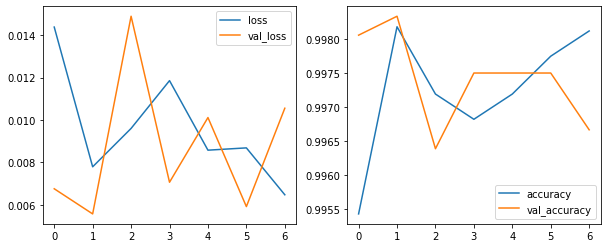

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

In [18]:
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        TEST_PATH,
        class_names=classes,
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100), 
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    predictions = predictions.ravel()
    test_labels = np.array(test_labels)

    return test_labels, predictions

In [19]:
y_true, y_pred = eval_model_on_test(lr_finetuned_resnet50)
predicted_labels = np.array([1 if p > 0.5 else 0 for p in y_pred])

Found 4000 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 32/32 [00:20<00:00,  1.56it/s]


In [20]:
print(classification_report(y_true, predicted_labels, 
                            target_names=classes))
pd.DataFrame(confusion_matrix(y_true, predicted_labels), 
             index=classes, columns=classes)

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00      2000
    positive       1.00      1.00      1.00      2000

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



,negative,positive
negative,1995,5
positive,2,1998


In [21]:
lr_finetuned_resnet50.save('kaggle/working/models/resnet50_transfer_learning')

2022-03-20 12:06:05.200340: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
